In [1]:
# read data
%matplotlib ipympl
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np


resp = loadmat('data4elio/resp.mat')['x']
pupil = loadmat('data4elio/smoothPupil.mat')['smoothPupil']
# meg = loadmat('data4elio/meg.mat')['meg']

# split in train and test set
from sklearn.model_selection import train_test_split

[Xtrain, Xtest, Ytrain, Ytest] = train_test_split(resp, pupil, train_size=.8, shuffle=False)



In [2]:
# lowpass the MEG data 
from local_funcs import butter_lowpass_filter

XtrainFilt = butter_lowpass_filter(Xtrain, .2, 300)
XtestFilt = butter_lowpass_filter(Xtest, .2, 300)
YtrainFilt = butter_lowpass_filter(Ytrain, .2, 300)
YtestFilt = butter_lowpass_filter(Ytest, .2, 300)



In [3]:
# bring the data into a more acceptable numeric range
from sklearn.preprocessing import RobustScaler


scalerX = RobustScaler().fit(XtrainFilt)
XtrainFiltScaled = scalerX.transform(XtrainFilt)
XtestFiltScaled = scalerX.transform(XtestFilt)

scalerY = RobustScaler().fit(YtrainFilt)
YtrainFiltScaled = np.tanh(scalerY.transform(YtrainFilt))
YtestFiltScaled = np.tanh(scalerY.transform(YtestFilt))



In [2]:
# compatibility

XtrainFiltScaled = Xtrain
XtestFiltScaled = Xtest

YtrainFiltScaled = Ytrain
YtestFiltScaled = Ytest



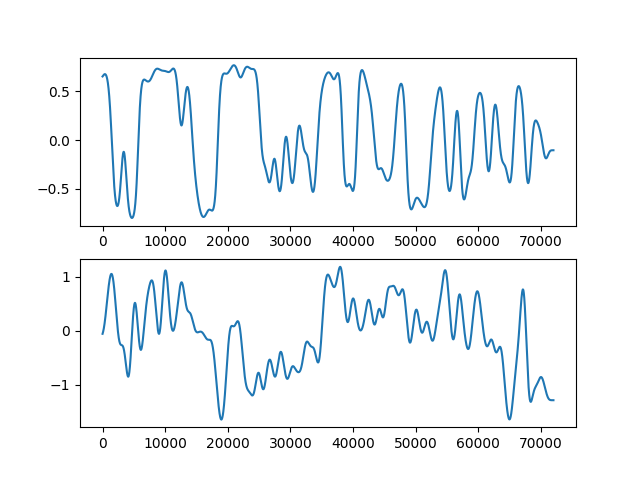

In [4]:
plt.figure()
plt.subplot(211)
plt.plot(YtrainFiltScaled)
plt.subplot(212)
plt.plot(XtrainFiltScaled[:, 42])

In [3]:
# import CEBRA & define model
import cebra
from cebra import CEBRA

cebra_model = CEBRA(model_architecture='offset10-model',
                    batch_size=512,
                    learning_rate= .0003,
                    temperature=1,
                    output_dimension=3,
                    max_iterations=1000,
                    distance='cosine',
                    conditional='time_delta',
                    device='cuda_if_available',
                    verbose=True,
                    time_offsets=10)


In [ ]:
# fit model
mdl_true = cebra_model.fit(XtrainFiltScaled, Ytrain)

# fit also a model on shuffled labels
from sklearn.utils import shuffle
shuffled_Ytrain = shuffle(YtrainFiltScaled)
mdl_shuffled = cebra_model.fit(XtrainFiltScaled, shuffled_Ytrain)


pos:  0.1662 neg:  6.0469 total:  6.2131 temperature:  1.0000:  55%|▌| 554/1000 

<Axes3D: title={'center': 'Embedding'}>

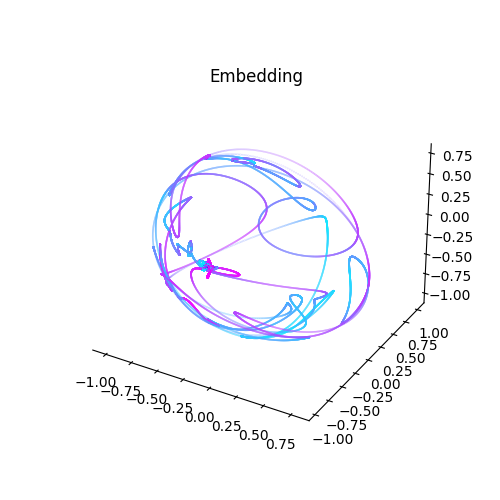

In [7]:
# fancy plots
embeds_true = mdl_true.transform(XtrainFiltScaled) 

cebra.plot_embedding(embeds_true, embedding_labels=Ytrain[:, 0])


<Axes3D: title={'center': 'Embedding'}>

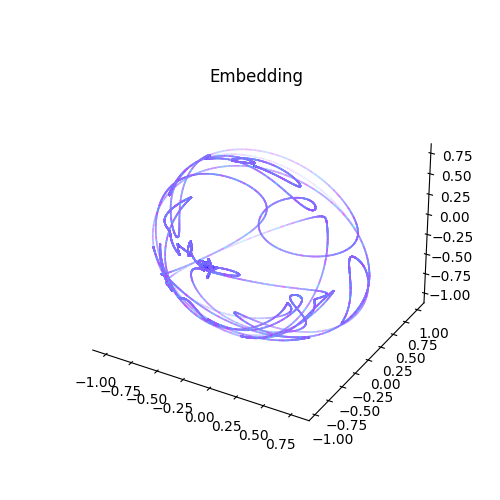

In [8]:
# sanity check 0: shuffled labels
embeds_shuffled = mdl_shuffled.transform(XtrainFiltScaled) 
cebra.plot_embedding(embeds_shuffled, embedding_labels=shuffled_Ytrain[:, 0])


In [ ]:
# sanity check 1: reconstruct respiration pattern from train data
from sklearn.neighbors import KNeighborsRegressor


resp_decoder = KNeighborsRegressor(n_neighbors=36, metric='cosine')
resp_decoder.fit(embeds_true, YtrainFiltScaled)

Ytrain_pred = resp_decoder.predict(embeds_true)

# test data 
embeds_true_test = mdl_true.transform(XtestFiltScaled)

Ytest_pred = resp_decoder.predict(embeds_true_test)

plt.figure()
plt.subplot(211)
plt.plot(YtrainFiltScaled)
plt.plot(Ytrain_pred)

plt.subplot(212)
plt.plot(YtestFiltScaled)
plt.plot(Ytest_pred)



In [ ]:
plt.figure()
plt.subplot(311)
plt.plot(short_resp, embeddings[:,0]) 
plt.subplot(312)
plt.plot(short_resp, embeddings[:,1]) 
plt.subplot(313)
plt.plot(short_resp, embeddings[:,2]) 